# 镜像与猫鼠游戏——反卷积生成网络与DCGAN

本文件是集智AI学园开发的“火炬上的深度学习”系列课程第五节课：《镜像网络与猫鼠游戏》的配套文档。在本文档中，我们实现了一个反卷积神经网络生成器，它可以通过输入的信号，生成一张逼真的手写数字图像。为了让我们的生成图像能够足够逼真，我们尝试了三种不同的方法：

1、在MINST数据集中，选出一个样本，输入数字标签，输出图像，并让输出的图像与样本图像尽可能相似，总误差最小化；
2、同上，只不过并不直接比较输出和样本相似性，而是让一个已训练好的手写数字识别网络来判断这个伪造的图像是几；
3、DCGAN，同时训练一个生成器一个判别器。每个时刻随机采样一个向量输入给生成器，它输出一张图像，同时读取一个数据样本，判别器判断样本图像
和生成图像的真假。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
image_size = 28
input_dim = 100
num_channels = 1
num_features = 64
batch_size = 64

use_cuda = torch.cuda.is_available()

dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

train_dataset = dsets.MNIST(root = "./data",
                            train = True,
                            transform = transforms.ToTensor(),
                            download = True)

test_dataset = dsets.MNIST(root = "./data",
                           train = False,
                           transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          sampler = sampler_test)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## 一、生成器预测图像模型

在这个模型中，我们根据输入的手写数字生成一张图像，并让这个图像与数据中的样本图像尽可能一致

In [3]:
class ModelG(nn.Module):
    def __init__(self):
        super(ModelG, self).__init__()
        self.model = nn.Sequential() #model为一个内嵌的序列化的神经网络模型
        
        # 利用add_module增加一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=3, 5*5
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim, num_features*2, 5, 2, 0, bias=False))
        self.model.add_module('bnorm1',nn.BatchNorm2d(num_features*2))
        self.model.add_module('relu1',nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2, num_features, 5, 2, 0, bias=False))
        self.model.add_module('bnorm2', nn.BatchNorm2d(num_features))
        self.model.add_module('relu2',nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        self.model.add_module('sigmoid',nn.Sigmoid())
        
    
    def forward(self, input):
        output = input
        for name, module in self.model.named_children():
            output = module(output)
        return(output) # 28*28
    
    
def weight_init(m):
    #模型参数初始化．
    #默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    #使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name=m.__class__.__name__
    if class_name.find('conv')!=-1:
        m.weight.data.normal_(0, 0.02)
    if class_name.find('norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(batch_size, 3, image_size, image_size)
    return img
def imshow(inp, title=None, ax=None):
    # 在屏幕上绘制图像
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)

In [6]:
print('Initialized!')

net = ModelG()
net = net.cuda() if use_cuda else net

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

# 随机选择生成0-9的数字，用于每个周期打印查看结果用
samples = np.random.choice(10, batch_size)
samples = torch.from_numpy(samples).type(dtype)

#开始训练
step = 0
num_epochs = 100
record = []
for epoch in range(num_epochs):
    train_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 注意数据中的data转化为了要预测的target，数据中的target则转化成了输入给网络的标签
        target, data = data.clone().detach().requires_grad_(True), target.clone().detach()
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        #将输入的数字标签转化为生成器net能够接受的(batch_size, input_dim, 1, 1)维张量
        data = data.type(dtype)
        data = data.resize(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)
        
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1
        
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy())
        
        if step % 100 == 0:
            net.eval()
            val_loss = []
            
            idx = 0
            for (data, target) in validation_loader:
                target, data = data.clone().detach(), target.clone().detach()
                idx += 1
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                data = data.type(dtype)
                data = data.resize(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                output = net(data)
                loss = criterion(output, target)
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy())
            print('训练周期：{} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f}\t校验数据Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), np.mean(val_loss)))
            record.append([np.mean(train_loss), np.mean(val_loss)])
            
            
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    # 改变输入数字的尺寸，适应于生成器网络
    samples.resize_(batch_size, 1, 1, 1)
    samples = samples.data.expand(batch_size, input_dim, 1, 1)
    samples = samples.cuda() if use_cuda else samples
    fake_u = net(samples)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u) #将张量转化成可绘制的图像
    vutil.save_image(img,'temp1/fake%s.png' % (epoch))

Initialized!
训练周期：0 [6336/60000 (11%)]	训练数据Loss: 0.262674	校验数据Loss: 0.244977
训练周期：0 [12736/60000 (21%)]	训练数据Loss: 0.243456	校验数据Loss: 0.210986
训练周期：0 [19136/60000 (32%)]	训练数据Loss: 0.228201	校验数据Loss: 0.188770
训练周期：0 [25536/60000 (43%)]	训练数据Loss: 0.215912	校验数据Loss: 0.172265
训练周期：0 [31936/60000 (53%)]	训练数据Loss: 0.205588	校验数据Loss: 0.158602
训练周期：0 [38336/60000 (64%)]	训练数据Loss: 0.196925	校验数据Loss: 0.147722
训练周期：0 [44736/60000 (75%)]	训练数据Loss: 0.189380	校验数据Loss: 0.139540
训练周期：0 [51136/60000 (85%)]	训练数据Loss: 0.182840	校验数据Loss: 0.133574
训练周期：0 [57536/60000 (96%)]	训练数据Loss: 0.177113	校验数据Loss: 0.127441
训练周期：1 [3904/60000 (7%)]	训练数据Loss: 0.125612	校验数据Loss: 0.123302
训练周期：1 [10304/60000 (17%)]	训练数据Loss: 0.123828	校验数据Loss: 0.119705
训练周期：1 [16704/60000 (28%)]	训练数据Loss: 0.121917	校验数据Loss: 0.115957
训练周期：1 [23104/60000 (38%)]	训练数据Loss: 0.120254	校验数据Loss: 0.112907
训练周期：1 [29504/60000 (49%)]	训练数据Loss: 0.118630	校验数据Loss: 0.110032
训练周期：1 [35904/60000 (60%)]	训练数据Loss: 0.117130	校验数据Loss: 0.107860
训练周期：1 [42304/6

训练周期：13 [32320/60000 (54%)]	训练数据Loss: 0.069769	校验数据Loss: 0.067093
训练周期：13 [38720/60000 (64%)]	训练数据Loss: 0.069753	校验数据Loss: 0.067228
训练周期：13 [45120/60000 (75%)]	训练数据Loss: 0.069707	校验数据Loss: 0.067073
训练周期：13 [51520/60000 (86%)]	训练数据Loss: 0.069714	校验数据Loss: 0.067007
训练周期：13 [57920/60000 (96%)]	训练数据Loss: 0.069696	校验数据Loss: 0.066992
训练周期：14 [4288/60000 (7%)]	训练数据Loss: 0.069356	校验数据Loss: 0.066961
训练周期：14 [10688/60000 (18%)]	训练数据Loss: 0.069336	校验数据Loss: 0.067047
训练周期：14 [17088/60000 (28%)]	训练数据Loss: 0.069311	校验数据Loss: 0.066901
训练周期：14 [23488/60000 (39%)]	训练数据Loss: 0.069300	校验数据Loss: 0.066834
训练周期：14 [29888/60000 (50%)]	训练数据Loss: 0.069338	校验数据Loss: 0.066752
训练周期：14 [36288/60000 (60%)]	训练数据Loss: 0.069302	校验数据Loss: 0.066712
训练周期：14 [42688/60000 (71%)]	训练数据Loss: 0.069283	校验数据Loss: 0.066654
训练周期：14 [49088/60000 (82%)]	训练数据Loss: 0.069252	校验数据Loss: 0.066513
训练周期：14 [55488/60000 (92%)]	训练数据Loss: 0.069223	校验数据Loss: 0.066520
训练周期：15 [1856/60000 (3%)]	训练数据Loss: 0.068494	校验数据Loss: 0.066561
训练周期：15 [8256/

训练周期：26 [51904/60000 (86%)]	训练数据Loss: 0.065884	校验数据Loss: 0.063209
训练周期：26 [58304/60000 (97%)]	训练数据Loss: 0.065880	校验数据Loss: 0.063220
训练周期：27 [4672/60000 (8%)]	训练数据Loss: 0.066023	校验数据Loss: 0.063112
训练周期：27 [11072/60000 (18%)]	训练数据Loss: 0.066035	校验数据Loss: 0.063184
训练周期：27 [17472/60000 (29%)]	训练数据Loss: 0.065873	校验数据Loss: 0.063168
训练周期：27 [23872/60000 (40%)]	训练数据Loss: 0.065773	校验数据Loss: 0.063118
训练周期：27 [30272/60000 (50%)]	训练数据Loss: 0.065781	校验数据Loss: 0.063188
训练周期：27 [36672/60000 (61%)]	训练数据Loss: 0.065804	校验数据Loss: 0.063201
训练周期：27 [43072/60000 (72%)]	训练数据Loss: 0.065835	校验数据Loss: 0.063109
训练周期：27 [49472/60000 (82%)]	训练数据Loss: 0.065845	校验数据Loss: 0.063195
训练周期：27 [55872/60000 (93%)]	训练数据Loss: 0.065789	校验数据Loss: 0.063135
训练周期：28 [2240/60000 (4%)]	训练数据Loss: 0.065488	校验数据Loss: 0.062975
训练周期：28 [8640/60000 (14%)]	训练数据Loss: 0.065638	校验数据Loss: 0.063187
训练周期：28 [15040/60000 (25%)]	训练数据Loss: 0.065723	校验数据Loss: 0.063098
训练周期：28 [21440/60000 (36%)]	训练数据Loss: 0.065678	校验数据Loss: 0.063057
训练周期：28 [27840/

训练周期：40 [11456/60000 (19%)]	训练数据Loss: 0.064272	校验数据Loss: 0.061733
训练周期：40 [17856/60000 (30%)]	训练数据Loss: 0.064440	校验数据Loss: 0.061649
训练周期：40 [24256/60000 (40%)]	训练数据Loss: 0.064467	校验数据Loss: 0.061842
训练周期：40 [30656/60000 (51%)]	训练数据Loss: 0.064358	校验数据Loss: 0.061806
训练周期：40 [37056/60000 (62%)]	训练数据Loss: 0.064353	校验数据Loss: 0.061798
训练周期：40 [43456/60000 (72%)]	训练数据Loss: 0.064416	校验数据Loss: 0.061964
训练周期：40 [49856/60000 (83%)]	训练数据Loss: 0.064404	校验数据Loss: 0.061722
训练周期：40 [56256/60000 (94%)]	训练数据Loss: 0.064403	校验数据Loss: 0.061659
训练周期：41 [2624/60000 (4%)]	训练数据Loss: 0.064121	校验数据Loss: 0.061689
训练周期：41 [9024/60000 (15%)]	训练数据Loss: 0.064357	校验数据Loss: 0.061630
训练周期：41 [15424/60000 (26%)]	训练数据Loss: 0.064171	校验数据Loss: 0.061550
训练周期：41 [21824/60000 (36%)]	训练数据Loss: 0.064241	校验数据Loss: 0.061617
训练周期：41 [28224/60000 (47%)]	训练数据Loss: 0.064224	校验数据Loss: 0.061638
训练周期：41 [34624/60000 (58%)]	训练数据Loss: 0.064196	校验数据Loss: 0.061567
训练周期：41 [41024/60000 (68%)]	训练数据Loss: 0.064235	校验数据Loss: 0.061539
训练周期：41 [4742

训练周期：53 [31040/60000 (52%)]	训练数据Loss: 0.063122	校验数据Loss: 0.060271
训练周期：53 [37440/60000 (62%)]	训练数据Loss: 0.063087	校验数据Loss: 0.060531
训练周期：53 [43840/60000 (73%)]	训练数据Loss: 0.063055	校验数据Loss: 0.060453
训练周期：53 [50240/60000 (84%)]	训练数据Loss: 0.063036	校验数据Loss: 0.060231
训练周期：53 [56640/60000 (94%)]	训练数据Loss: 0.062989	校验数据Loss: 0.060494
训练周期：54 [3008/60000 (5%)]	训练数据Loss: 0.062859	校验数据Loss: 0.060307
训练周期：54 [9408/60000 (16%)]	训练数据Loss: 0.062971	校验数据Loss: 0.060379
训练周期：54 [15808/60000 (26%)]	训练数据Loss: 0.062950	校验数据Loss: 0.060403
训练周期：54 [22208/60000 (37%)]	训练数据Loss: 0.063006	校验数据Loss: 0.060273
训练周期：54 [28608/60000 (48%)]	训练数据Loss: 0.062969	校验数据Loss: 0.060303
训练周期：54 [35008/60000 (58%)]	训练数据Loss: 0.062990	校验数据Loss: 0.060331
训练周期：54 [41408/60000 (69%)]	训练数据Loss: 0.063001	校验数据Loss: 0.060266
训练周期：54 [47808/60000 (80%)]	训练数据Loss: 0.062979	校验数据Loss: 0.060195
训练周期：54 [54208/60000 (90%)]	训练数据Loss: 0.063014	校验数据Loss: 0.060456
训练周期：55 [576/60000 (1%)]	训练数据Loss: 0.062254	校验数据Loss: 0.060200
训练周期：55 [6976/60

训练周期：66 [50624/60000 (84%)]	训练数据Loss: 0.062484	校验数据Loss: 0.059702
训练周期：66 [57024/60000 (95%)]	训练数据Loss: 0.062471	校验数据Loss: 0.059734
训练周期：67 [3392/60000 (6%)]	训练数据Loss: 0.062091	校验数据Loss: 0.059910
训练周期：67 [9792/60000 (16%)]	训练数据Loss: 0.062255	校验数据Loss: 0.059783
训练周期：67 [16192/60000 (27%)]	训练数据Loss: 0.062279	校验数据Loss: 0.059758
训练周期：67 [22592/60000 (38%)]	训练数据Loss: 0.062414	校验数据Loss: 0.059792
训练周期：67 [28992/60000 (48%)]	训练数据Loss: 0.062445	校验数据Loss: 0.059635
训练周期：67 [35392/60000 (59%)]	训练数据Loss: 0.062458	校验数据Loss: 0.059946
训练周期：67 [41792/60000 (70%)]	训练数据Loss: 0.062498	校验数据Loss: 0.059805
训练周期：67 [48192/60000 (80%)]	训练数据Loss: 0.062511	校验数据Loss: 0.059835
训练周期：67 [54592/60000 (91%)]	训练数据Loss: 0.062516	校验数据Loss: 0.059733
训练周期：68 [960/60000 (2%)]	训练数据Loss: 0.062225	校验数据Loss: 0.059772
训练周期：68 [7360/60000 (12%)]	训练数据Loss: 0.062491	校验数据Loss: 0.059852
训练周期：68 [13760/60000 (23%)]	训练数据Loss: 0.062471	校验数据Loss: 0.059752
训练周期：68 [20160/60000 (34%)]	训练数据Loss: 0.062428	校验数据Loss: 0.059736
训练周期：68 [26560/60

训练周期：80 [10176/60000 (17%)]	训练数据Loss: 0.062267	校验数据Loss: 0.059488
训练周期：80 [16576/60000 (28%)]	训练数据Loss: 0.062383	校验数据Loss: 0.059616
训练周期：80 [22976/60000 (38%)]	训练数据Loss: 0.062417	校验数据Loss: 0.059470
训练周期：80 [29376/60000 (49%)]	训练数据Loss: 0.062250	校验数据Loss: 0.059489
训练周期：80 [35776/60000 (60%)]	训练数据Loss: 0.062209	校验数据Loss: 0.059518
训练周期：80 [42176/60000 (70%)]	训练数据Loss: 0.062232	校验数据Loss: 0.059459
训练周期：80 [48576/60000 (81%)]	训练数据Loss: 0.062209	校验数据Loss: 0.059509
训练周期：80 [54976/60000 (92%)]	训练数据Loss: 0.062178	校验数据Loss: 0.059447
训练周期：81 [1344/60000 (2%)]	训练数据Loss: 0.061322	校验数据Loss: 0.059566
训练周期：81 [7744/60000 (13%)]	训练数据Loss: 0.061840	校验数据Loss: 0.059432
训练周期：81 [14144/60000 (24%)]	训练数据Loss: 0.062012	校验数据Loss: 0.059669
训练周期：81 [20544/60000 (34%)]	训练数据Loss: 0.061985	校验数据Loss: 0.059578
训练周期：81 [26944/60000 (45%)]	训练数据Loss: 0.062013	校验数据Loss: 0.059410
训练周期：81 [33344/60000 (56%)]	训练数据Loss: 0.062053	校验数据Loss: 0.059635
训练周期：81 [39744/60000 (66%)]	训练数据Loss: 0.062144	校验数据Loss: 0.059368
训练周期：81 [4614

训练周期：93 [29760/60000 (50%)]	训练数据Loss: 0.061884	校验数据Loss: 0.059304
训练周期：93 [36160/60000 (60%)]	训练数据Loss: 0.061890	校验数据Loss: 0.059171
训练周期：93 [42560/60000 (71%)]	训练数据Loss: 0.061911	校验数据Loss: 0.059288
训练周期：93 [48960/60000 (82%)]	训练数据Loss: 0.061913	校验数据Loss: 0.059224
训练周期：93 [55360/60000 (92%)]	训练数据Loss: 0.061886	校验数据Loss: 0.059400
训练周期：94 [1728/60000 (3%)]	训练数据Loss: 0.061286	校验数据Loss: 0.059370
训练周期：94 [8128/60000 (14%)]	训练数据Loss: 0.061936	校验数据Loss: 0.059202
训练周期：94 [14528/60000 (24%)]	训练数据Loss: 0.061890	校验数据Loss: 0.059274
训练周期：94 [20928/60000 (35%)]	训练数据Loss: 0.061889	校验数据Loss: 0.059283
训练周期：94 [27328/60000 (46%)]	训练数据Loss: 0.061880	校验数据Loss: 0.059194
训练周期：94 [33728/60000 (56%)]	训练数据Loss: 0.061893	校验数据Loss: 0.059290
训练周期：94 [40128/60000 (67%)]	训练数据Loss: 0.061905	校验数据Loss: 0.059257
训练周期：94 [46528/60000 (78%)]	训练数据Loss: 0.061900	校验数据Loss: 0.059195
训练周期：94 [52928/60000 (88%)]	训练数据Loss: 0.061867	校验数据Loss: 0.059247
训练周期：94 [59328/60000 (99%)]	训练数据Loss: 0.061884	校验数据Loss: 0.059214
训练周期：95 [5696

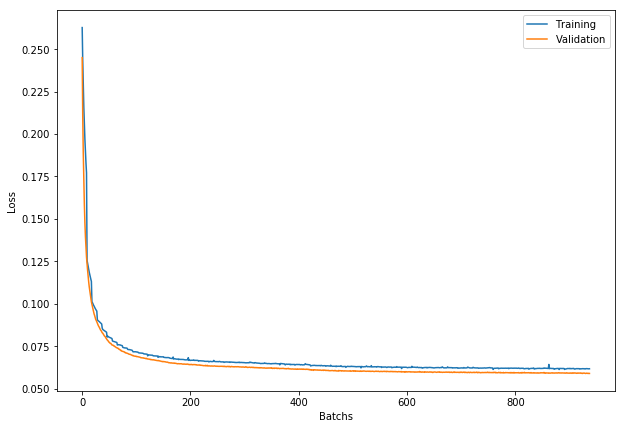

In [7]:
plt.figure(figsize = (10, 7))
plt.plot([i[0] for i in record], label='Training')
plt.plot([i[1] for i in record], label='Validation')
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.legend()

<Figure size 1080x1080 with 0 Axes>

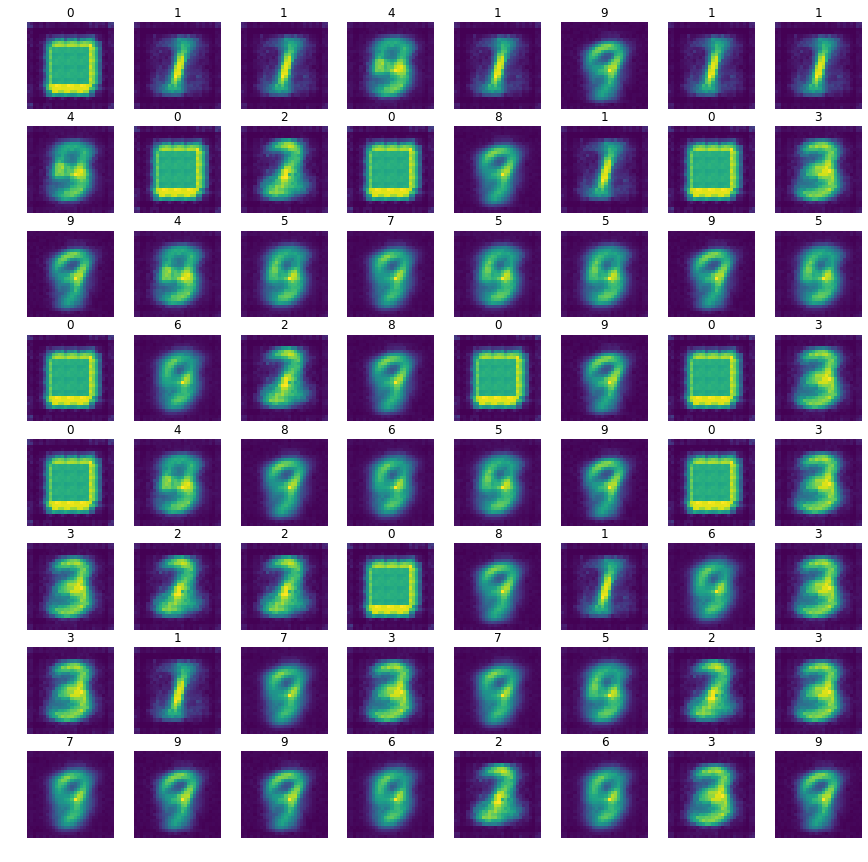

In [8]:
# 绘制一批图像样本
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u.data
fig = plt.figure(figsize = (15, 15))

f, axarr = plt.subplots(8, 8, sharex=True, figsize=(15, 15))
for i in range(batch_size):
    
    axarr[i // 8, i % 8].axis('off')
    imshow(img[i],
           samples.data.numpy()[i][0, 0, 0].astype(int),
           axarr[i // 8, i % 8])